In [1]:
import pandas as pd
import numpy as np
import folium
import json
import matplotlib.pyplot as plt
import webbrowser
from datetime import date, datetime,timedelta
import warnings

In [2]:
def catch_distribution():
    url = ("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/")
    try:
        df = pd.read_csv(url + date.today().strftime("%m-%d-%Y") +".csv", error_bad_lines=False)
    except:
        df = pd.read_csv(url + datetime.strftime(datetime.now() - timedelta(1), '%m-%d-%Y') +".csv", error_bad_lines=False)
    df.loc[df['Country/Region'] == 'Taiwan*', ['Province/State','Country/Region']] = ['Taiwan', 'China']
    return df

In [8]:
def china_map():
    warnings.filterwarnings("ignore")
    df_world = catch_distribution()
    df_china = df_world.loc[(df_world['Country/Region'] == 'China')]
    df_china['Current'] = df_china['Confirmed'] - df_china['Recovered'] - df_china['Deaths']
    
    fname = "chinamap.geojson" 
    with open(fname, encoding='utf-8') as data_file:
        china_geo = json.load(data_file)
    myscale = [0,1,10,100,200,250000]
    
    map1 = folium.Map(location=[34.001684, 108.736552], zoom_start = 4.3)
    
    map1.choropleth(geo_data = china_geo,
                      data = df_china,
                      columns = ['Province/State','Current'],
                      key_on = 'feature.properties.Name_1',
                      fill_color = 'Reds',
                      threshold_scale = myscale,
                      fill_opacity = 0.7,
                      highlight = True,
                      legend_name = 'COVID-19 China Data')
    for lat, lon, confirmed, death, recovered, name in zip(df_china['Latitude'], df_china['Longitude'], df_china['Confirmed'], df_china['Deaths'], df_china['Recovered'], df_china['Province/State']):
        folium.CircleMarker([lat, lon],
                            radius = 3,
                            popup = ('<strong>Province/City</strong>: ' + str(name) + '<br>'
                                    '<strong>Confirmed</strong>: ' + str(confirmed) + '<br>'
                                     '<strong>Deaths</strong>: ' + str(death) + '<br>'
                                     '<strong>Recovered</strong>: ' + str(recovered) + '<br>'),
                            color = 'red',
                            fill_color = 'red',
                            fill_opacity = 0.7 ).add_to(map1)
    return map1

In [9]:
def usa_map():
    df_world = catch_distribution()
    df_usa = df_world.loc[(df_world['Country/Region'] == 'US')]
    
    fname = "usamap.geojson" 
    with open(fname, encoding='utf-8') as data_file:
        usa_geo = json.load(data_file)
    myscale = [0,1,5,10,40,100,200,500,1000]
    map2 = folium.Map(location=[38.203457, -94.618874], zoom_start = 5)
    
    map2.choropleth(geo_data = usa_geo,
                      data = df_usa,
                      columns = ['Province/State','Confirmed'],
                      key_on = 'feature.properties.NAME',
                      popup = df_usa['Province/State'],
                      fill = True,
                      fill_color = 'Reds',
                      nan_fill_color='white',
                      threshold_scale = myscale,
                      fill_opacity = 0.5,
                      legend_name = 'COVID-19 USA Data',
                      highlight = True)
    
    for lat, lon, confirmed, death, recovered, name in zip(df_usa['Latitude'], df_usa['Longitude'], df_usa['Confirmed'], df_usa['Deaths'], df_usa['Recovered'], df_usa['Province/State']):
        folium.CircleMarker([lat, lon],
                            radius = 3,
                            popup = ('<strong>State</strong>: ' + str(name) + '<br>'
                                    '<strong>Confirmed</strong>: ' + str(confirmed) + '<br>'
                                     '<strong>Deaths</strong>: ' + str(death) + '<br>'
                                     '<strong>Recovered</strong>: ' + str(recovered) + '<br>'),
                            color = 'red',
                            fill_color = 'red',
                            fill_opacity = 0.7 ).add_to(map2)
    for lat, lon, confirmed, death, recovered, name in zip(df_usa['Latitude'], df_usa['Longitude'], df_usa['Confirmed'], df_usa['Deaths'], df_usa['Recovered'], df_usa['Province/State']):
        text = folium.Html(('<strong>State</strong>: ' + str(name) + '<br>'
                             '<strong>Confirmed</strong>: ' + str(confirmed) + '<br>'
                             '<strong>Deaths</strong>: ' + str(death) + '<br>'
                             '<strong>Recovered</strong>: ' + str(recovered) + '<br>'), script=True)
        folium.Popup(text).add_to(map2)
    return map2

In [10]:
def world_map():
    warnings.filterwarnings("ignore")
    df_world = catch_distribution()
    
    c = {}
    d = {}
    r = {}
    for i in df_world['Country/Region'].unique():
        c[i] = sum([df_world['Confirmed'][j] for j in df_world[df_world['Country/Region'] == i].index])
        d[i] = sum([df_world['Deaths'][j] for j in df_world[df_world['Country/Region'] == i].index])
        r[i] = sum([df_world['Recovered'][j] for j in df_world[df_world['Country/Region'] == i].index])
    df_Confirmed = pd.Series(c).to_frame()
    df_Confirmed = df_Confirmed.reset_index()
    df_Confirmed.columns = ['Country/Region','Confirmed']
    df_Deaths = pd.Series(d).to_frame()
    df_Deaths = df_Deaths.reset_index()
    df_Deaths.columns = ['Country/Region','Deaths']
    df_Recovered = pd.Series(r).to_frame()
    df_Recovered = df_Recovered.reset_index()
    df_Recovered.columns = ['Country/Region','Recovered']
    df_country = df_Confirmed
    df_country['Deaths'] = df_Deaths['Deaths']
    df_country['Recovered'] = df_Recovered['Recovered']
    
    
    f = {}
    g = {}
    for i in df_world['Country/Region'].unique():
        f[i] = np.mean([df_world['Latitude'][j] for j in df_world[df_world['Country/Region'] == i].index])
        g[i] = np.mean([df_world['Longitude'][j] for j in df_world[df_world['Country/Region'] == i].index])
    df_lat = pd.Series(f).to_frame()
    df_lat = df_lat.reset_index()
    df_lat.columns = ['Country/Region','Latitude']
    df_lgt = pd.Series(g).to_frame()
    df_lgt = df_lgt.reset_index()
    df_lgt.columns = ['Country/Region','Longitude']
    df_country['Latitude'] = df_lat['Latitude']
    df_country['Longitude'] = df_lgt['Longitude']
    
    fname = "worldmap.geojson" 
    with open(fname, encoding='utf-8') as data_file:
        world_geo = json.load(data_file)
    myscale = [0,10,100,1000,2000,100000]
    map3 = folium.Map(location=[36.070080, 45.611698], zoom_start = 2)
    
    map3.choropleth(geo_data = world_geo,
                      data = df_country,
                      columns = ['Country/Region','Confirmed'],
                      key_on = 'feature.properties.sovereignt',
                      fill = True,
                      fill_color = 'Reds',
                      nan_fill_color='white',
                      threshold_scale = myscale,
                      fill_opacity = 0.5,
                      legend_name = 'COVID-19 World Data',
                      highlight = True)
    
    for lat, lon, confirmed, death, recovered, name in zip(df_country['Latitude'], df_country['Longitude'], df_country['Confirmed'], df_country['Deaths'], df_country['Recovered'], df_country['Country/Region']):
        folium.CircleMarker([lat, lon],
                            radius = 3,
                            popup = ('<strong>Contry/Region</strong>: ' + str(name) + '<br>'
                                    '<strong>Confirmed</strong>: ' + str(confirmed) + '<br>'
                                     '<strong>Deaths</strong>: ' + str(death) + '<br>'
                                     '<strong>Recovered</strong>: ' + str(recovered) + '<br>'),
                            color = 'red',
                            fill_color = 'red',
                            fill_opacity = 0.7 ).add_to(map3)
    
    return map3

In [6]:
def plot():
    url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
    df_Confirmed = pd.read_csv(url, error_bad_lines=False)
    df_Confirmed.loc[df_Confirmed['Country/Region'] == 'Taiwan*', ['Province/State','Country/Region']] = ['Taiwan', 'China']
    
    url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'
    df_Recovered = pd.read_csv(url, error_bad_lines=False)
    df_Recovered.loc[df_Confirmed['Country/Region'] == 'Taiwan*', ['Province/State','Country/Region']] = ['Taiwan', 'China']
    
    url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
    df_Death = pd.read_csv(url, error_bad_lines=False)
    df_Death.loc[df_Confirmed['Country/Region'] == 'Taiwan*', ['Province/State','Country/Region']] = ['Taiwan', 'China']
    
    df = df_Confirmed.iloc[:,0:4]
    for i in range(4,len(df_Confirmed.columns)-1):
        df[df_Confirmed.columns[i]] = df_Confirmed[df_Confirmed.columns[i]] - df_Recovered[df_Confirmed.columns[i]] - df_Death[df_Confirmed.columns[i]]
    df_country = pd.DataFrame({'Country' : df['Country/Region'].unique()}) 
    
    country = []
    while(1):
        country_list = []
        for i in df_country['Country']:
            country_list.append(i.lower())
        s = str(input('Please enter the country name: ')).lower()
        if s in 'United States of America' or s in 'USA':
            s = 'us'
        elif s.lower() in 'korea, south' or s.lower() in 'south korea':
            s = 'korea, south'
        if s in country_list:
            country.append(s)
        else:
            print('Invalid country name, please enter again.')
        s = str(input('Do you wanna add another country? (y/n): ')).lower()
        if s == 'n':
            break
        elif s == 'y':
            continue
        
    count = []
    for item in country:
        if df.loc[df['Country/Region'] == item.capitalize()].empty == False:
            df_count = df.loc[df['Country/Region'] == item.capitalize()]
        elif item.lower() == 'korea, south':
            df_count = df.loc[df['Country/Region'] == 'Korea, South']
        else:
            df_count = df.loc[df['Country/Region'] == item.upper()]
        date = []
        country_count = []
        for (i, Data) in df.iloc[:,4:-1].iteritems():
            date.append(i[0:-3])
            country_count.append(sum(df_count[i]))
        count.append(country_count)
    
    plt.figure(figsize=(12, 8))
    fig, ax = plt.subplots()
    for i in range(len(country)):
        if country[i] == 'us':
            country[i] = 'US'
        elif country[i] == 'korea, south':
            country[i] = 'South Korea'
        else:
            country[i] = country[i].capitalize()
        ax.plot(date, count[i], label = country[i])
    ax.xaxis.set_major_locator(plt.MultipleLocator(5))
    plt.xlabel('Date')
    plt.ylabel('Confirmed Cases')
    ax.legend(frameon=False)
    plt.gcf().autofmt_xdate()
    plt.grid(linestyle=':')
    plt.show()

In [11]:
usa_map()

In [35]:
world_map()

In [12]:
china_map()

Please enter the country name: US
Do you wanna add another country? (y/n): y
Please enter the country name: Italy
Do you wanna add another country? (y/n): y
Please enter the country name: Korea
Do you wanna add another country? (y/n): n


<Figure size 864x576 with 0 Axes>

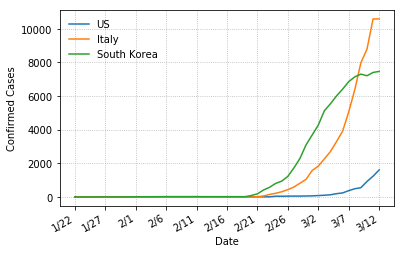

In [13]:
plot()